In [1]:
import glob
import os
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import ascii
from astropy.table import Table
from astroquery.simbad import Simbad
import arviz as az

import pandas as pd    
from datetime import date
today=date.today()
DATE =today.strftime("%m_%d_%y")
print(DATE)
# from utils import *
from astropy import units as u
from astropy import constants as const

from utils import *

04_10_25


In [2]:
data0 = pd.read_csv('binary_params.csv')

In [3]:
galah = Table.read('../../lithium/data/GALAH_DR3_main_allstar_v2.fits').to_pandas()

In [4]:
galah_vac = Table.read('../../lithium/data/GALAH_DR3_VAC_ages_v2.fits').to_pandas()

In [5]:
data = pd.merge(data0, galah_vac[['sobject_id','m_act_bstep','e_m_act_bstep']], left_on='galah_id', right_on='sobject_id')


In [6]:
def get_msini(K, P, e, Mstar):
    '''
    Get Mp sin(i), the minimum mass of the companion.
    @input:
        K: semi-amplitude in km/s
        P: period in days
        e: eccentricity
        M: mass of the star in solar masses
    
    '''
    from scipy import optimize
    
    # convert units to SI units
    K = (K*(u.km/u.second)).to(u.meter/u.second)
    P = (P*u.day).to(u.second)
    Mstar = (Mstar*u.M_sun).to(u.kg)
    e = e*u.dimensionless_unscaled
    
    # define constants
    pi = np.pi
    G  = const.G
    
    # if Mp << Mstar:
    Msini = (Mstar)**(2./3.) * np.sqrt(1-e**2.) * K * (P/(2*pi*G))**(1./3.)
    
    # else:
    a = np.sqrt(1-e**2.) * K * (P/(2*pi*G))**(1./3.)
    #Msini = (Mstar+Mp)**(2./3.) * a
    #fx = (Mstar+Mp)**(2./3.) * a - Msini
    
    Mjup = u.M_jup.to(u.kg)
    Msun = u.Msun.to(u.kg)
    #print(Mjup)
    def func(x, a, Mstar):
        return x - (Mstar + x)**(2./3.) * a # x = Msini

    from scipy.optimize import brentq, bisect, fsolve
    from scipy.optimize import fsolve

    sol   = optimize.root(func, Msun, args=(a.value, Mstar.value) )
    Msini = sol.x
    
    #root  = brentq(func, 0.1, Msun , args=(a.value, Mstar.value))
    
    return Msini, sol.success
    
# get_msini(1,1,1,1)
    

In [70]:
for i, row in data.iterrows():
#     if i != 1: continue
    K, P, e, Mstar = row['K'], row['P'], row['e'], row['m_act_bstep']
    K = abs(K)
    K = 0.4
    Msini, success = get_msini(K, P, e, Mstar)
    Msini_jup   = Msini/u.M_jup.to(u.kg)
    Msini_solar = Msini/u.Msun.to(u.kg)
    
    if success:
        if i != 5: continue
        print(K, P, e, Mstar)
        print(i,'%.2f Mstar \t %.3f Mjup \t %.3f Msun' % (Mstar, Msini_jup, Msini_solar))

0.4 20.694 0.181 0.9565468227493464
5 0.96 Mstar 	 5.177 Mjup 	 0.005 Msun


<ipython-input-70-37a5abeaa62c>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(i,'%.2f Mstar \t %.3f Mjup \t %.3f Msun' % (Mstar, Msini_jup, Msini_solar))


# M/W analysis

In [8]:
df_final = Table.read('../../lithium/final_paper_sample_09_18.csv').to_pandas()


In [18]:
PLOT_PARAMS(LS=12,SIZE=12)
# plt.rcParams['figure.facecolor']    = 'white'
# 

index 0 is out of bounds for axis 0 with size 0


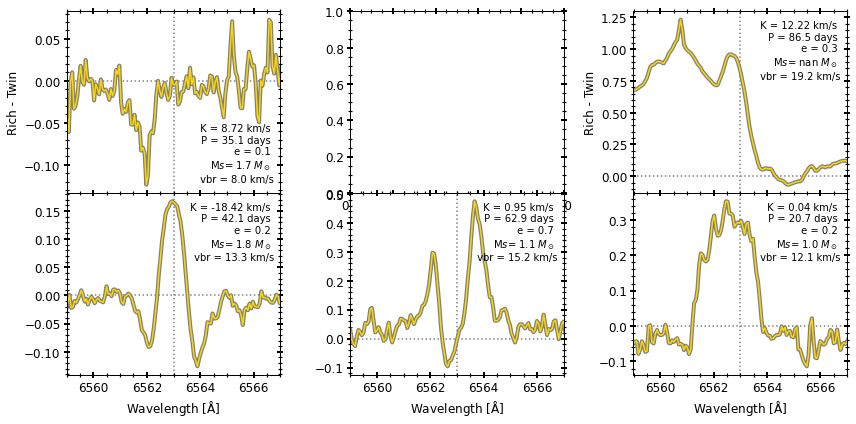

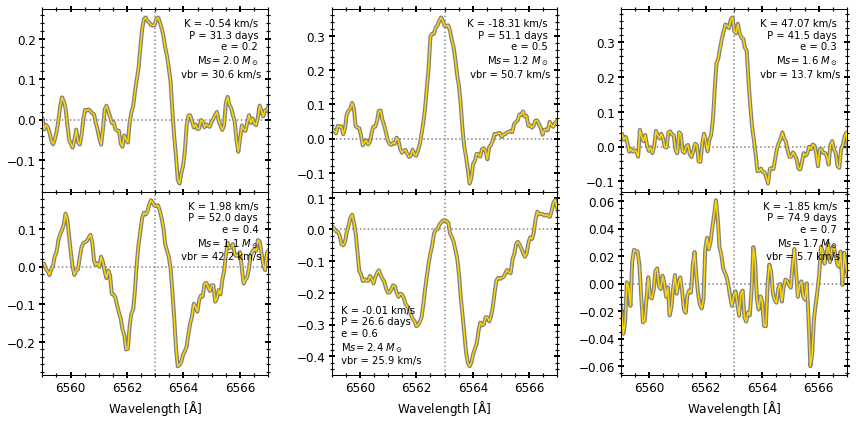

In [58]:
def get_mw(rid, ax, label):
    pid = df_final[df_final.galah_rich_id==rid].galah_poor_id.to_numpy()[0]
    rich_spectrum=get_spectra(rid,'rich',False)

    poor_spectrum=get_spectra(pid,'poor',)
    rwave_og = rich_spectrum['wave_norm_3']
    rflux_og = rich_spectrum['sob_norm_3']
    rerr     = rich_spectrum['uob_norm_3']

    pwave_og = poor_spectrum['wave_norm_3']
    pflux_og = poor_spectrum['sob_norm_3']
    perr     = poor_spectrum['uob_norm_3']

    wavelength_grid  = np.linspace(min(rwave_og),max(rwave_og),len(rwave_og))


    _,rflux = interpolate_to_grid(xdata=rwave_og, ydata=rflux_og, xgrid=wavelength_grid)
    _,pflux = interpolate_to_grid(xdata=pwave_og, ydata=pflux_og, xgrid=wavelength_grid)
    _,rerr  = interpolate_to_grid(xdata=rwave_og, ydata=rerr,  xgrid=wavelength_grid)
    _,perr  = interpolate_to_grid(xdata=pwave_og, ydata=perr,  xgrid=wavelength_grid)
    diff    = rflux-pflux
    x,dx    = 6563, 5
    x,dA  = 6563,5
    llim,ulim=x-dA,x+dA
    mask  = (wavelength_grid <= ulim) & (wavelength_grid>=llim)
    wavelength_grid = wavelength_grid[mask]
    rflux = rflux[mask]
    pflux = pflux[mask] 
    ax.plot(wavelength_grid,rflux-pflux,c='grey', lw=4, label=label)
    ax.plot(wavelength_grid,rflux-pflux,c='gold')
    ax.axvline(x,c='grey',ls='dotted',zorder=0)
    ax.axhline(0,c='grey',ls='dotted',zorder=0)
    ax.set_xlim(llim+1, ulim-1)
    #ax.legend()
    
fig = plt.figure(figsize=(12,6))
for i, row in data.iterrows():
    K, P, e, Mstar = row['K'], row['P'], row['e'], row['m_act_bstep']
    vbroad = row['vbroad']
    rid = row['galah_id']
    #print(rid)
    if i > 5: continue
    ax = plt.subplot(2,3,i+1)
    try:
        
        label = ' K = %.2f km/s \n P = %.1f days \n e = %.1f \n M$s$= %.1f $M_\odot$ \n vbr = %.1f km/s' % (K, P, e, Mstar,vbroad)
        get_mw(rid, ax, label)

        #ax.legend(fontsize=12,)
        #if i<3:
        #    ax.text(0.5, 1.01, label, fontsize=11, ha='center',va='bottom', transform = ax.transAxes)
        #else:
        
        if i == 0:
            ax.text(0.97, 0.05, label, fontsize=10, ha='right',va='bottom', transform = ax.transAxes)
        else:
            ax.text(0.97, 0.95, label, fontsize=10, ha='right',va='top', transform = ax.transAxes)
            
        if i in [0,1,2]: ax.set_ylabel('Rich - Twin')
        if i > 2: 
            ax.set_xlabel('Wavelength ['+r'$\mathrm{\AA}$'+']')
        if i in [0,1,2]:
            ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
        
    except Exception as e:
        print(e)
plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.savefig('../plots/m_vs_w_1_%s.png'%DATE,bbox_inches='tight',dpi=150)

fig = plt.figure(figsize=(12,6))
for i, row in data.iterrows():
    K, P, e, Mstar = row['K'], row['P'], row['e'], row['m_act_bstep']
    vbroad = row['vbroad']
    rid = row['galah_id']
    if i < 6: continue
    n = i-6+1
    ax = plt.subplot(2,3,n)
    try:
        label = ' K = %.2f km/s \n P = %.1f days \n e = %.1f \n M$s$= %.1f $M_\odot$ \n vbr = %.1f km/s' % (K, P, e, Mstar,vbroad)
        get_mw(rid, ax, label)
        if n==5:
            ax.text(0.03, 0.05, label, fontsize=10, ha='left',va='bottom', transform = ax.transAxes)
        else:
            ax.text(0.97, 0.95, label, fontsize=10, ha='right',va='top', transform = ax.transAxes)
            
        if i in [0,1,2]: ax.set_ylabel('Rich - Twin')
        if i > 2: 
            ax.set_xlabel('Wavelength ['+r'$\mathrm{\AA}$'+']')
        if i in [0,1,2]:
            ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
        
    except Exception as e:
        print(e)
plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.savefig('../plots/m_vs_w_2_%s.png'%DATE,bbox_inches='tight',dpi=150)
